In [27]:
import logging

# ===== START LOGGER =====
logger = logging.getLogger(__name__)
root_logger = logging.getLogger()
root_logger.setLevel(logging.INFO)
sh = logging.StreamHandler()
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
sh.setFormatter(formatter)
root_logger.addHandler(sh)

import os
import numpy as np
import pandas as pd
import requests
import datetime
import matplotlib.pyplot as plt# Load the dataset using pandas
data = pd.read_csv("GOOG.csv") 
data.head(5)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-06-08,533.309998,534.119995,526.239990,526.830017,526.830017,1520600
1,2015-06-09,527.559998,529.200012,523.010010,526.690002,526.690002,1455300
2,2015-06-10,529.359985,538.359985,529.349976,536.690002,536.690002,1815000
3,2015-06-11,538.424988,538.979980,533.020020,534.609985,534.609985,1217500
4,2015-06-12,531.599976,533.119995,530.159973,532.330017,532.330017,955800


In [28]:
# ========== FUNCTION TO GET STOCK DATA ==========
def get_stock_data(tkn, sym='amzn', start_date='2020-01-01'):
    headers = {'Content-Type': 'application/json'}

    requestResponse = requests.get("https://api.tiingo.com/tiingo/daily/" + sym + "/prices?startDate=" + start_date + "&token=" + tkn, headers=headers)
    if requestResponse.status_code == 200:
        logger.info(f'Success fetching {sym} data from {start_date} to today')
    else:
        logger.warning(f'Something looks wrong - status code {requestResponse.status_code}')

    return requestResponse


# ========== GET STOCK DATA ==========

def dl_stock_df(symbols_in, start_date='2015-01-01'):
    # TODO - add error handling
    ticker_datas = []
    for sym in symbols_in:
        temp_data = get_stock_data(tiingo_token, sym=sym, start_date=start_date).json()
        temp_df = pd.DataFrame(temp_data)
        temp_df['sym'] = sym
        ticker_datas.append(temp_df)

    # Concatenate stock data
    return pd.concat(ticker_datas)

In [29]:
# ========== LOAD TOKENS / SET CONSTANTS==========
if 'TIINGO_KEY' in os.environ:
    tiingo_token = os.environ['TIINGO_KEY']
else:
    with open('tiingo_token.txt', 'r') as f:
        tiingo_token = f.read().strip()

In [30]:
symbols_ser = ['AAPL', 'MSFT', 'JNJ', 'WMT', 'TSM', 'UAL', 'NMIH']  # For testing
total_ticker_df = dl_stock_df(symbols_ser)

format_str="%Y-%m-%dT%H:%M:%S.%fZ"
total_ticker_df['date'] = pd.to_datetime(total_ticker_df['date'], format=format_str)

INFO:__main__:Success fetching AAPL data from 2015-01-01 to today
2020-06-23 08:43:52,369 - __main__ - INFO - Success fetching AAPL data from 2015-01-01 to today
INFO:__main__:Success fetching MSFT data from 2015-01-01 to today
2020-06-23 08:43:54,332 - __main__ - INFO - Success fetching MSFT data from 2015-01-01 to today
INFO:__main__:Success fetching JNJ data from 2015-01-01 to today
2020-06-23 08:43:56,284 - __main__ - INFO - Success fetching JNJ data from 2015-01-01 to today
INFO:__main__:Success fetching WMT data from 2015-01-01 to today
2020-06-23 08:43:58,275 - __main__ - INFO - Success fetching WMT data from 2015-01-01 to today
INFO:__main__:Success fetching TSM data from 2015-01-01 to today
2020-06-23 08:44:00,319 - __main__ - INFO - Success fetching TSM data from 2015-01-01 to today
INFO:__main__:Success fetching UAL data from 2015-01-01 to today
2020-06-23 08:44:02,149 - __main__ - INFO - Success fetching UAL data from 2015-01-01 to today
INFO:__main__:Success fetching NMIH 

In [31]:
data

,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-06-08,533.309998,534.119995,526.239990,526.830017,526.830017,1520600
1,2015-06-09,527.559998,529.200012,523.010010,526.690002,526.690002,1455300
2,2015-06-10,529.359985,538.359985,529.349976,536.690002,536.690002,1815000
3,2015-06-11,538.424988,538.979980,533.020020,534.609985,534.609985,1217500
4,2015-06-12,531.599976,533.119995,530.159973,532.330017,532.330017,955800
...,...,...,...,...,...,...,...
1257,2020-06-04,1430.400024,1438.959961,1404.729980,1412.180054,1412.180054,1484300
1258,2020-06-05,1413.170044,1445.050049,1406.000000,1438.390015,1438.390015,1734900
1259,2020-06-08,1422.339966,1447.989990,1422.339966,1446.609985,1446.609985,1404200
1260,2020-06-09,1445.359985,1468.000000,1443.209961,1456.160034,1456.160034,1409200


In [42]:
data = total_ticker_df.query("sym == 'NMIH'")

In [43]:
# Select only the important features i.e. the date and price
data = data[["date","close"]] # select Date and Price
# Rename the features: These names are NEEDED for the model fitting
data = data.rename(columns = {"date":"ds","close":"y"}) #renaming the columns of the dataset
data.head(5)

,ds,y
0,2015-01-02,9.15
1,2015-01-05,8.94
2,2015-01-06,8.73
3,2015-01-07,8.34
4,2015-01-08,8.33


In [44]:
from fbprophet import Prophet
m = Prophet(daily_seasonality = True) # the Prophet class (model)
m.fit(data) # fit the model using all data

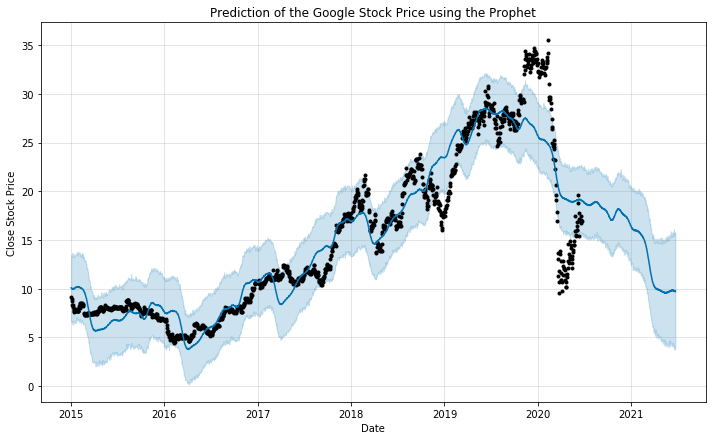

In [45]:
future = m.make_future_dataframe(periods=365) #we need to specify the number of days in future
prediction = m.predict(future)
m.plot(prediction)
plt.title("Prediction of the Google Stock Price using the Prophet")
plt.xlabel("Date")
plt.ylabel("Close Stock Price")
plt.show()

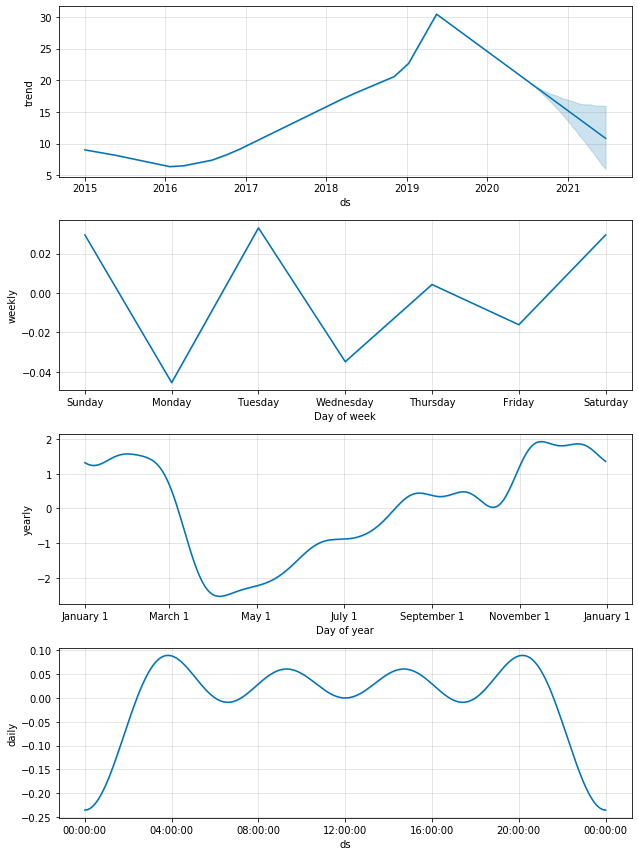

In [46]:
m.plot_components(prediction)
plt.show()